---

# Notebook : Analyse des corrélations et sélection des variables (Mise à jour)

**Objectif :** Identifier les variables les plus corrélées avec la cible (`nutriscore_grade`), visualiser les corrélations, puis sélectionner les variables pertinentes pour la modélisation. La sélection finale sera sauvegardée dans un nouveau dossier pour les analyses ultérieures.

---

## Étape 1 : Importer les bibliothèques nécessaires et charger les données

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Charger le fichier de données préparées
file_path = 'note-books/phase_2_training/03_feature_selection/data_selected_features.csv'
df = pd.read_csv(file_path)

# Afficher un aperçu des données
print("Aperçu des premières lignes du jeu de données sélectionné :")
df.head()

Aperçu des premières lignes du jeu de données sélectionné :


/var/folders/l_/z4yzpdw13r1_992xyftwcsmr0000gn/T/ipykernel_4702/3122432786.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,code,product_name,brands,categories,countries,main_category,nutriscore_grade,pnns_groups_1,pnns_groups_2,food_groups,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g
0,9050482371038,Pain de mie extra moelleux sans sucres ajoutÃ©s,"Lidl,MaÃ®tre Jean Pierre",Pains de mie,France,en:sliced-breads,b,Cereals and potatoes,Bread,en:bread,277.0,1159.0,5.1,0.8,48.8,5.0,7.4,1.17,0.468
1,9050482388685,Vegan Protein Bar Almond Cookie Dough,IronMaxx,NahrungsergÃ¤nzungsmittel,en:Germany,en:protein-bars,d,unknown,unknown,NaN,361.0,1511.0,14.7,8.1,28.6,3.2,0.0,0.68,0.272
2,9050482407287,cuajada,Milbona,Lcteos,en:es,en:cuajada,b,Milk and dairy products,Dairy desserts,en:dairy-desserts,93.0,389.0,5.3,3.4,6.4,6.4,4.9,0.20,0.080
3,9050482450139,Salad cheese Greek Style,Milbona,Lcteos,Spain,en:greek-cheeses,d,Milk and dairy products,Cheese,en:cheese,247.0,1026.0,20.0,0.0,0.8,0.8,16.0,2.50,1.000
4,9050482487661,Fusilli,Lidl,Pflanzliche Lebensmittel und GetrÃ¤nke,Allemagne,af:fusilli,a,Cereals and potatoes,Cereals,en:cereals,377.0,1577.0,1.0,0.5,77.2,3.7,13.6,0.08,0.032


---

## Étape 2 : Encodage de la variable cible pour la corrélation

Pour calculer la corrélation, nous encodons `nutriscore_grade` en valeurs numériques.

In [20]:
# Encodage de `nutriscore_grade` en valeurs numériques (A=0, B=1, etc.)
df['nutriscore_grade_encoded'] = df['nutriscore_grade'].map({'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4})

# Vérifier l'encodage
df[['nutriscore_grade', 'nutriscore_grade_encoded']].head()

,nutriscore_grade,nutriscore_grade_encoded
0,b,1
1,d,3
2,b,1
3,d,3
4,a,0


---

## Étape 3 : Calculer et visualiser la matrice de corrélation complète

Nous calculons la matrice de corrélation et visualisons les corrélations des variables numériques pour obtenir une vue d'ensemble.

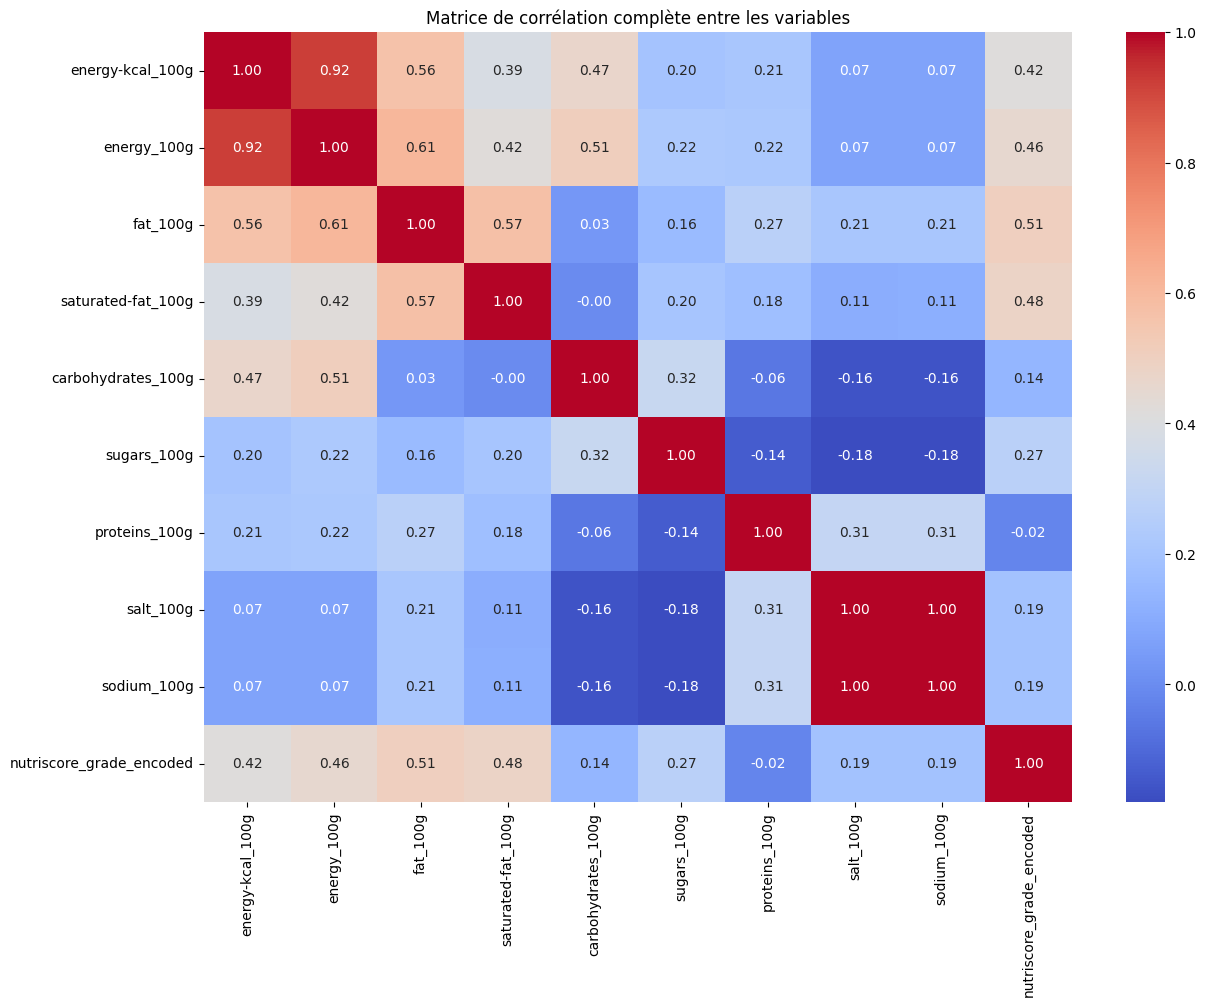

In [21]:
# Sélectionner uniquement les colonnes numériques pour la matrice de corrélation
numerical_df = df.select_dtypes(include=['number'])

# Calculer la matrice de corrélation
correlation_matrix = numerical_df.corr()

# Visualiser la matrice de corrélation complète
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice de corrélation complète entre les variables")
plt.show()

---

## Étape 4 : Visualisation ciblée des corrélations avec `nutriscore_grade_encoded`

Nous nous concentrons sur les corrélations avec `nutriscore_grade_encoded` en extrayant et triant ces corrélations.

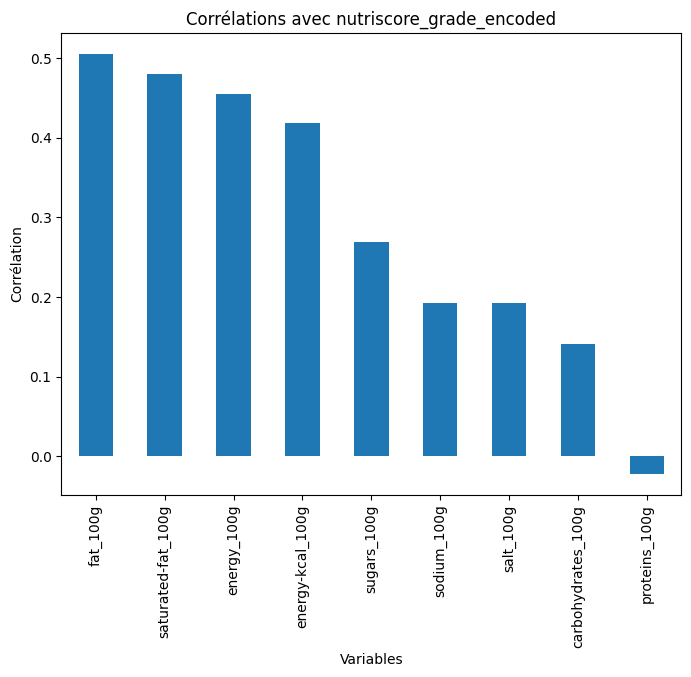

In [22]:
# Extraire et trier les corrélations avec `nutriscore_grade_encoded`
correlation_target = correlation_matrix['nutriscore_grade_encoded'].drop('nutriscore_grade_encoded').sort_values(ascending=False)

# Afficher un graphique des corrélations avec la cible
plt.figure(figsize=(8, 6))
correlation_target.plot(kind='bar')
plt.title("Corrélations avec nutriscore_grade_encoded")
plt.xlabel("Variables")
plt.ylabel("Corrélation")
plt.show()

---

## Étape 5 : Sélection des variables pertinentes

Nous sélectionnons les variables ayant une corrélation absolue avec `nutriscore_grade_encoded` supérieure à un seuil (ex. : 0,2) et ajoutons des variables distinctives (`product_name`, `brands`, `categories`) pour identifier les produits.

In [23]:
# Seuil de corrélation (ajustable)
correlation_threshold = 0.2

# Extraire les variables avec une corrélation absolue supérieure au seuil
relevant_features = correlation_target[correlation_target.abs() > correlation_threshold].index.tolist()

# Ajouter manuellement `salt_100g` et `proteins_100g` si elles sont absentes mais nécessaires
if 'salt_100g' not in relevant_features:
    relevant_features.append('salt_100g')
if 'proteins_100g' not in relevant_features:
    relevant_features.append('proteins_100g')

# Supprimer l'une des colonnes d'énergie si les deux sont présentes
if 'energy_100g' in relevant_features and 'energy-kcal_100g' in relevant_features:
    relevant_features.remove('energy_100g')  # Choix de garder `energy-kcal_100g`, par exemple

# Ajouter les variables distinctives pour l'identification des produits
distinctive_features = ['product_name', 'brands', 'categories']
relevant_features += distinctive_features

# Créer un DataFrame avec les variables pertinentes et distinctives
df_selected_features = df[relevant_features + ['nutriscore_grade']]

# Afficher les variables sélectionnées
print("Variables sélectionnées pour la modélisation :")
print(relevant_features)


Variables sélectionnées pour la modélisation :
['fat_100g', 'saturated-fat_100g', 'energy-kcal_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'product_name', 'brands', 'categories']


---

## Étape 6 : Sauvegarder le sous-ensemble de variables pour la modélisation dans un nouveau dossier

Nous enregistrons le DataFrame contenant les variables pertinentes dans un nouveau dossier **04_correlation_analysis**.

In [24]:
# Définir le dossier de sortie
output_folder = 'note-books/phase_2_training/04_correlation_analysis'

# Créer le dossier s'il n'existe pas
os.makedirs(output_folder, exist_ok=True)

# Définir le chemin complet pour le fichier des variables sélectionnées
output_path = os.path.join(output_folder, 'data_final_features.csv')

# Sauvegarder le DataFrame des variables sélectionnées
df_selected_features.to_csv(output_path, index=False)

print(f"Fichier des variables sélectionnées sauvegardé sous : {output_path}")

Fichier des variables sélectionnées sauvegardé sous : note-books/phase_2_training/04_correlation_analysis/data_final_features.csv


---

### Résumé

Dans ce notebook, nous avons :
1. Chargé les données nettoyées.
2. Encodé `nutriscore_grade` pour calculer la corrélation.
3. Calculé et visualisé la matrice de corrélation complète.
4. Visualisé les corrélations entre chaque variable et `nutriscore_grade_encoded`.
5. Sélectionné les variables pertinentes pour la modélisation, en ajoutant des variables distinctives pour l’identification des produits.
6. Sauvegardé les données finales dans `data_final_features.csv` dans le dossier `04_correlation_analysis`.

---
